In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize)

In [2]:
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

## Exercise 13

In [3]:
Weekly=load_data("Weekly")

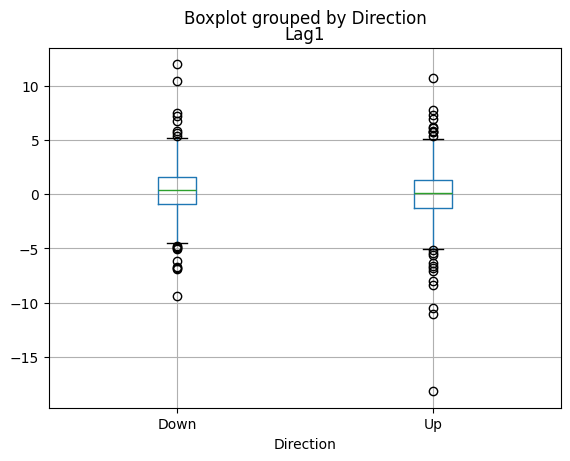

In [4]:
Weekly.boxplot('Lag1', by='Direction');

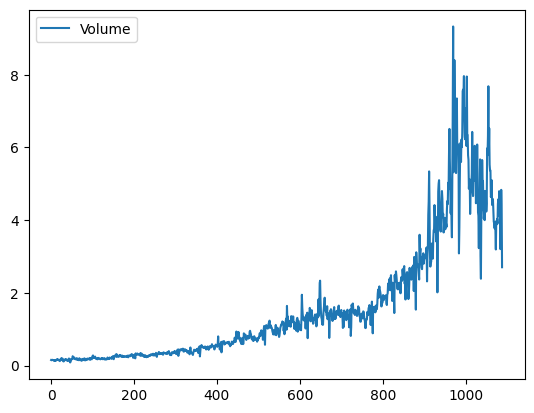

In [5]:
Weekly.plot(y="Volume"); #Volume increases over time

In [55]:
x=sm.add_constant(Weekly[Weekly.columns.drop(['Today', 'Direction', 'Year'])])
y = Weekly.Direction == 'Up'
glm = sm.GLM(y,
             x,
             family=sm.families.Binomial())
results = glm.fit()
results.summary() #small p-value for intercept and Lag2

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Direction   No. Observations:                 1089
Model:                            GLM   Df Residuals:                     1082
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -743.18
Date:                Sat, 11 May 2024   Deviance:                       1486.4
Time:                        13:06:22   Pearson chi2:                 1.09e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.009000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.026     -1.563      0.118      -0.093       0.010
Lag2           0.0584      0.027      2.175      0.030       0.006       0.111
Lag3          -0.0161      0.027     -0.602      0.547      -0.068       0.036
Lag4          -0.0278      0.026     -1.050      0.294      -0.080       0.024
Lag5          -0.0145      0.026     -0.549      0.583      -0.066       0.037
Volume        -0.0227      0.037     -0.616      0.538      -0.095       0.050
==============================================================================
"""

In [56]:
probs = results.predict()
labels = np.array(['Down']*1089)
labels[probs>0.5] = "Up"

In [57]:
confusion_table(labels, Weekly.Direction) #The prediction is often up


Truth,Down,Up
Predicted,,
Down,54,48
Up,430,557


In [58]:
np.mean(labels == Weekly.Direction)

0.5610651974288338

In [59]:
np.mean(Weekly.Direction=='Up') #We are slightly better than saying Up everytime

0.5555555555555556

d)

In [92]:
booltraining= Weekly.Year<2009
trainingdf=Weekly.loc[booltraining]
testdf=Weekly.loc[~booltraining]

In [94]:
testdf;

In [61]:
x=sm.add_constant(trainingdf["Lag2"])
y = trainingdf.Direction == 'Up'  # we need to work with booleans otherwise we have an error
glm = sm.GLM(y,
             x,
             family=sm.families.Binomial())
results = glm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Direction   No. Observations:                  985
Model:                            GLM   Df Residuals:                      983
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -675.27
Date:                Sat, 11 May 2024   Deviance:                       1350.5
Time:                        13:06:45   Pearson chi2:                     985.
No. Iterations:                     4   Pseudo R-squ. (CS):           0.004221
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2033      0.064      3.162      0.002       0.077       0.329
Lag2           0.0581      0.029      2.024      0.043       0.002       0.114
==============================================================================
"""

In [62]:
probs = results.predict(exog=sm.add_constant(testdf['Lag2']))
labels = np.array(['Down']*104)
labels[probs>0.5] = 'Up'


In [63]:
realresults=testdf["Direction"]

In [64]:
confusion_table(labels,realresults)

Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


In [65]:
np.mean(labels == testdf.Direction)

0.625

e)

In [95]:
lda = LDA(store_covariance=True)
y = trainingdf.Direction

In [76]:
lda.fit(trainingdf["Lag2"].to_frame(),y) # Transform a single column (i.e. a series) into a dataframe because otherwise we have an error

LinearDiscriminantAnalysis(store_covariance=True)

In [77]:
results = lda.predict(testdf['Lag2'].to_frame())


In [79]:
confusion_table(results, realresults)

Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


In [80]:
np.mean(results == testdf.Direction)

0.625

f)

In [96]:
qda = QDA(store_covariance=True)
qda.fit(trainingdf["Lag2"].to_frame(),y)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [97]:
results = qda.predict(testdf['Lag2'].to_frame())


In [99]:
confusion_table(results, realresults) #We always predict true

Truth,Down,Up
Predicted,,
Down,0,0
Up,43,61


In [101]:
np.mean(results == testdf.Direction)

0.5865384615384616

g)

In [102]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(trainingdf["Lag2"].to_frame(),y)

KNeighborsClassifier(n_neighbors=1)

In [103]:
results = knn1.predict(testdf['Lag2'].to_frame())

In [104]:
confusion_table(results, realresults)

Truth,Down,Up
Predicted,,
Down,22,31
Up,21,30


In [106]:
np.mean(results==testdf.Direction)

0.5

In [107]:
knn1 = KNeighborsClassifier(n_neighbors=5)
knn1.fit(trainingdf["Lag2"].to_frame(),y)
results = knn1.predict(testdf['Lag2'].to_frame())
confusion_table(results, realresults)

Truth,Down,Up
Predicted,,
Down,16,21
Up,27,40


In [108]:
np.mean(results==testdf.Direction)

0.5384615384615384

In [109]:
knn1 = KNeighborsClassifier(n_neighbors=3)
knn1.fit(trainingdf["Lag2"].to_frame(),y)
results = knn1.predict(testdf['Lag2'].to_frame())
confusion_table(results, realresults)

Truth,Down,Up
Predicted,,
Down,16,20
Up,27,41


In [110]:
np.mean(results==testdf.Direction)

0.5480769230769231

h)

In [117]:
NB = GaussianNB()
NB.fit(trainingdf["Lag2"].to_frame(),y)
results = NB.predict(testdf['Lag2'].to_frame())
confusion_table(results, realresults) #Prediction is always up, same as QDA

Truth,Down,Up
Predicted,,
Down,0,0
Up,43,61


In [116]:
np.mean(results==testdf.Direction)

0.5865384615384616

The best results are Logistic regression and LDA (62.5%)

## Exercise 14

In [118]:
Auto=load_data("Auto")

In [126]:
Auto['mpg1']=np.where(Auto['mpg']>=Auto["mpg"].median(),1,0)

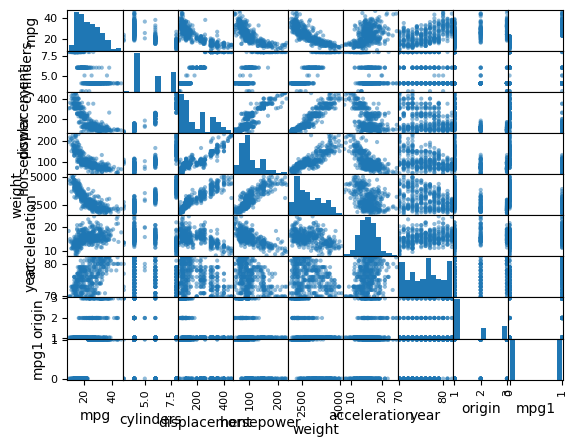

In [128]:
pd.plotting.scatter_matrix(Auto);

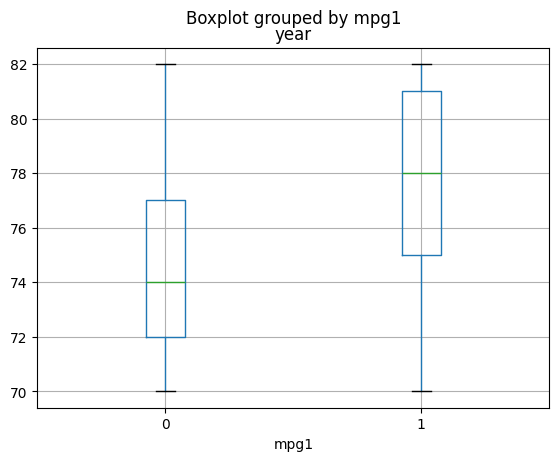

In [131]:
Auto.boxplot('year', by='mpg1');

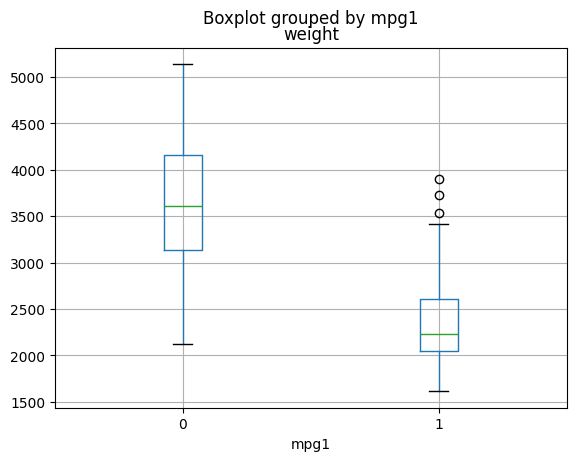

In [132]:
Auto.boxplot('weight', by='mpg1');

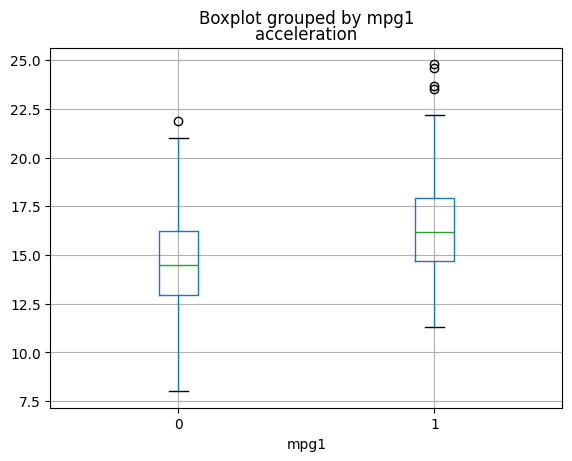

In [133]:
Auto.boxplot('acceleration', by='mpg1');

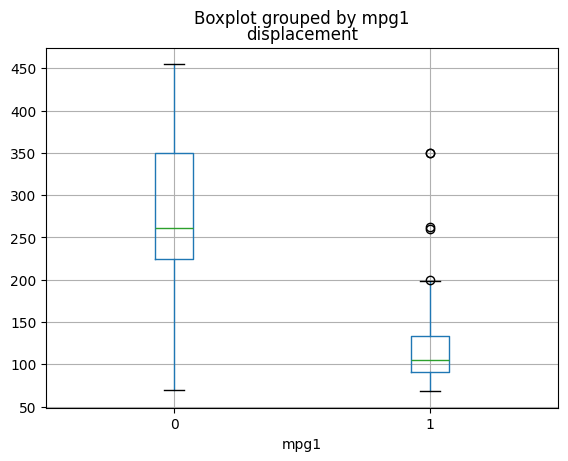

In [134]:
Auto.boxplot('displacement', by='mpg1');

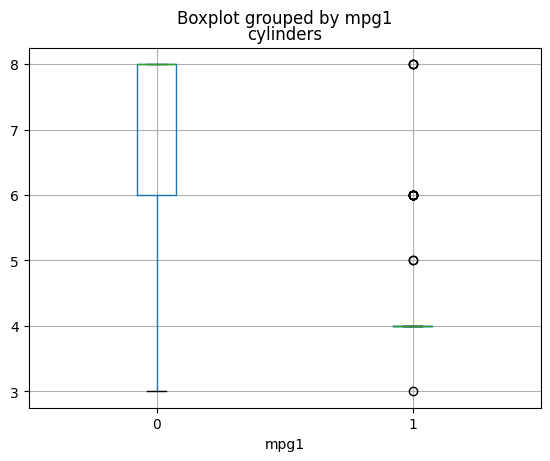

In [135]:
Auto.boxplot('cylinders', by='mpg1');

In [136]:
Auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg1
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu,0
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320,0
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite,0
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst,0
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino,0
...,...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl,1
388,44.0,4,97.0,52,2130,24.6,82,2,vw pickup,1
389,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage,1
390,28.0,4,120.0,79,2625,18.6,82,1,ford ranger,1


In [146]:
x=Auto[['cylinders','displacement','weight','year']]
y=Auto['mpg1']
(x_train,
 x_test,
 y_train,
 y_test) = train_test_split(x,
                            y,
                            test_size=0.2,
                            random_state=0) #20% of the data is in the test set


In [153]:
lda = LDA(store_covariance=True)
lda.fit(x_train,y_train) 

LinearDiscriminantAnalysis(store_covariance=True)

In [154]:
results=lda.predict(x_test)

In [155]:
confusion_table(results,y_test)

Truth,0,1
Predicted,,
0,34,2
1,8,35


In [156]:
np.mean(results==y_test)

0.8734177215189873

In [162]:
qda = QDA(store_covariance=True)
qda.fit(x_train,y_train) 
results2=qda.predict(x_test)
confusion_table(results2,y_test)

Truth,0,1
Predicted,,
0,34,2
1,8,35


In [163]:
np.mean(results2==y_test) # Same results as LDA

0.8734177215189873

In [171]:
Log = LogisticRegression() #This syntax is more similar to LDA, QDA,... and is not the one in the book
Log.fit(x_train,y_train) 
results3=Log.predict(x_test)
confusion_table(results3,y_test)

Truth,0,1
Predicted,,
0,34,2
1,8,35


In [170]:
np.mean(results3==y_test)  #Same proportion but the predictions are different

0.8734177215189873

In [172]:
NB = GaussianNB() 
NB.fit(x_train,y_train) 
results4=NB.predict(x_test)
confusion_table(results4,y_test)

Truth,0,1
Predicted,,
0,35,3
1,7,34


In [174]:
np.mean(results4==y_test)  #Same proportion but the confusion tables are different

0.8734177215189873

In [179]:
for i in range(1,18):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    results5 = knn.predict(x_test)
    print(np.mean(results5==y_test)) #Best value for K=2 and K=4

0.8860759493670886
0.8987341772151899
0.8734177215189873
0.8987341772151899
0.8481012658227848
0.8607594936708861
0.8481012658227848
0.8354430379746836
0.8354430379746836
0.8354430379746836
0.8354430379746836
0.8354430379746836
0.8354430379746836
0.8227848101265823
0.8227848101265823
0.8227848101265823
0.810126582278481


In [181]:
#The results of all the methods are pretty similar

## Exercise 15

In [3]:
def Power2(x,a):
    print(x**a)

In [4]:
Power2(3,17)

129140163


In [5]:
def Power3(x,a):
    return x**a

In [6]:
Power3(3,17)

129140163

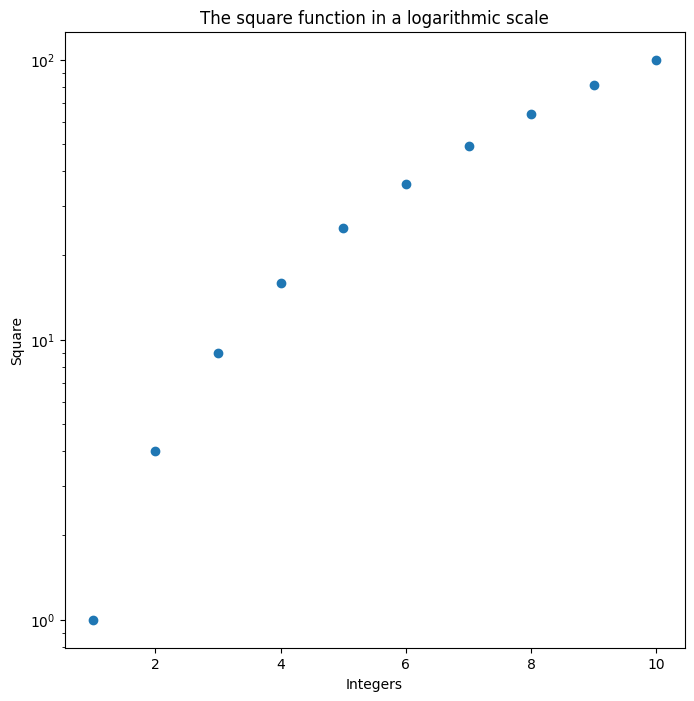

In [20]:
ax = subplots(figsize=(8,8))[1] 
ax.scatter(np.arange(1,11), Power3(np.arange(1,11),2))
ax.set_xlabel('Integers')
ax.set_ylabel('Square')
ax.set_title('The square function in a logarithmic scale')
ax.set_yscale("log")

In [22]:
def PlotPower(x,a):
    ax = subplots(figsize=(8,8))[1] 
    ax.scatter(x, Power3(x,a))
    ax.set_title('Some plot')


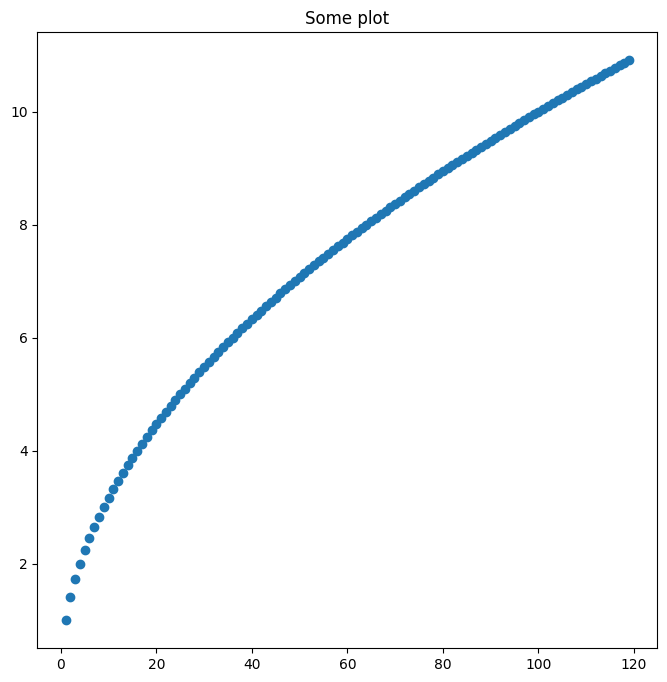

In [25]:
PlotPower(np.arange(1,120),0.5)

## Exercise 16

In [26]:
Boston=load_data("Boston")

In [28]:
Boston['crim1']=np.where(Boston['crim']>=Boston["crim"].median(),1,0)

In [30]:
Boston.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv,crim1
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,22.532806,0.500000
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,9.197104,0.500495
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000,0.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,17.025000,0.000000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,21.200000,0.500000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,25.000000,1.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,50.000000,1.000000


In [40]:
Boston.columns.drop(['crim','crim1'])

Index(['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat', 'medv'],
      dtype='object')

In [42]:
Boston.corr() # zn, chas, ptratio and rm are the variables that are least correlated with crim

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv,crim1
crim,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,0.455621,-0.388305,0.409395
zn,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,-0.412995,0.360445,-0.436151
indus,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,0.603800,-0.483725,0.603260
chas,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,-0.053929,0.175260,0.070097
nox,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,0.590879,-0.427321,0.723235
rm,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,-0.613808,0.695360,-0.156372
age,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,0.602339,-0.376955,0.613940
dis,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,-0.496996,0.249929,-0.616342
rad,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,0.488676,-0.381626,0.619786
tax,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,0.543993,-0.468536,0.608741


In [48]:
x=Boston[Boston.columns.drop(['zn','chas','ptratio','rm','crim','crim1'])]
y=Boston["crim1"]
(x_train,
 x_test,
 y_train,
 y_test) = train_test_split(x,
                            y,
                            test_size=0.2,
                            random_state=0) #20% of the data is in the test set

In [50]:
lda = LDA(store_covariance=True)
lda.fit(x_train,y_train) 
results=lda.predict(x_test)
np.mean(results==y_test)

0.8823529411764706

In [51]:
qda = QDA(store_covariance=True)
qda.fit(x_train,y_train) 
results=qda.predict(x_test)
np.mean(results==y_test)

0.8921568627450981

In [58]:
LR = LogisticRegression(max_iter=3000) #https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter
LR.fit(x_train,y_train) 
results=LR.predict(x_test)
np.mean(results==y_test)

0.8529411764705882

In [59]:
NB = GaussianNB()
NB.fit(x_train,y_train) 
results=NB.predict(x_test)
np.mean(results==y_test)

0.8627450980392157

In [61]:
for i in range(1,18):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    results5 = knn.predict(x_test)
    print(i,np.mean(results5==y_test))

1 0.9019607843137255
2 0.9019607843137255
3 0.8823529411764706
4 0.9117647058823529
5 0.9117647058823529
6 0.9215686274509803
7 0.9019607843137255
8 0.9117647058823529
9 0.9117647058823529
10 0.9117647058823529
11 0.8921568627450981
12 0.8725490196078431
13 0.8725490196078431
14 0.8725490196078431
15 0.8627450980392157
16 0.8627450980392157
17 0.8431372549019608


In [62]:
#The best result seems to be KNN with K=6

In [63]:
#Now let's try with all the predictors

In [64]:
x=Boston[Boston.columns.drop(['crim','crim1'])]
y=Boston["crim1"]
(x_train,
 x_test,
 y_train,
 y_test) = train_test_split(x,
                            y,
                            test_size=0.2,
                            random_state=0) #20% of the data is in the test set

In [65]:
lda = LDA(store_covariance=True)
lda.fit(x_train,y_train) 
results=lda.predict(x_test)
np.mean(results==y_test)

0.8823529411764706

In [66]:
qda = QDA(store_covariance=True)
qda.fit(x_train,y_train) 
results=qda.predict(x_test)
np.mean(results==y_test)

0.8921568627450981

In [68]:
LR = LogisticRegression(max_iter=3000) 
LR.fit(x_train,y_train) 
results=LR.predict(x_test)
np.mean(results==y_test)

0.8431372549019608

In [69]:
NB = GaussianNB()
NB.fit(x_train,y_train) 
results=NB.predict(x_test)
np.mean(results==y_test)

0.8333333333333334

In [70]:
for i in range(1,18):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    results5 = knn.predict(x_test)
    print(i,np.mean(results5==y_test))

1 0.9509803921568627
2 0.9411764705882353
3 0.9215686274509803
4 0.9411764705882353
5 0.9215686274509803
6 0.9411764705882353
7 0.9313725490196079
8 0.9215686274509803
9 0.9215686274509803
10 0.9117647058823529
11 0.9019607843137255
12 0.9019607843137255
13 0.9019607843137255
14 0.8921568627450981
15 0.8823529411764706
16 0.8823529411764706
17 0.8627450980392157


In [71]:
#The results are pretty similar, and a bit better with KNN. K=1 seems to be the best